#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [49]:
df_stock1 = pd.read_csv("../static/data/wbc.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df_stock3 = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock3.iloc[:-1,:]
# Drop last 3 columns sentiment RBA FED
N=3
df = df_stock_less1.iloc[: , :-N]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/01/2000,10.435952,10.435952,10.435952,10.435952,3.437588,0.0
1,4/01/2000,10.448864,10.448864,10.240284,10.240284,3.373133,2324971.0
2,5/01/2000,10.063487,10.081366,10.001907,10.051568,3.310971,2456811.0
3,6/01/2000,10.081366,10.111163,9.942312,10.031704,3.304429,4354261.0
4,7/01/2000,10.031704,10.061501,9.982042,10.031704,3.304429,2360114.0


<AxesSubplot:>

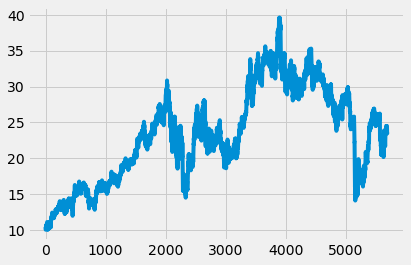

In [50]:
df["Close"].plot()

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5651 entries, 0 to 5683
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5651 non-null   object 
 1   Open       5651 non-null   float64
 2   High       5651 non-null   float64
 3   Low        5651 non-null   float64
 4   Close      5651 non-null   float64
 5   Adj Close  5651 non-null   float64
 6   Volume     5651 non-null   float64
dtypes: float64(6), object(1)
memory usage: 353.2+ KB


In [52]:
data = df.filter(['Close'])
dataset = data.values
dataset.shape


(5651, 1)

# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [53]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4521, 1)

In [54]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.01366231, 0.00704935, 0.00067134, 0.        , 0.        ,
       0.00359179, 0.00386034, 0.00402818, 0.00704935, 0.01208457,
       0.02181938, 0.02249075, 0.01812687, 0.01879824, 0.01376299,
       0.01342732, 0.01208457, 0.01208457, 0.01715339, 0.0234978 ,
       0.01819402, 0.01376299, 0.01678415, 0.02282646, 0.02205437,
       0.02551192, 0.02745885, 0.03625377, 0.03289693, 0.02181938,
       0.01913391, 0.01544141, 0.01074185, 0.00268546, 0.        ,
       0.00167842, 0.        , 0.00268546, 0.00201409, 0.01342732,
       0.00201409, 0.01007048, 0.02239004, 0.01611278, 0.01040615,
       0.01040615, 0.01054042, 0.01342732, 0.0234978 , 0.02685463,
       0.02282646, 0.02249075, 0.02685463, 0.02886872, 0.02685463,
       0.0177912 , 0.01443436, 0.01611278, 0.00738502, 0.01510574])]
[0.010775413823760738]


# Prepare train data for LSTM model

In [55]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4461, 60)

In [56]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4461, 60, 1)

# Build the LSTM model

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [58]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [59]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4461/4461 [==============================] - 63s 14ms/step - loss: 0.0014


In [60]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [61]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [62]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [63]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

1.596281671931606

C:\Users\antoi\AppData\Local\Temp/ipykernel_1000/3268862602.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


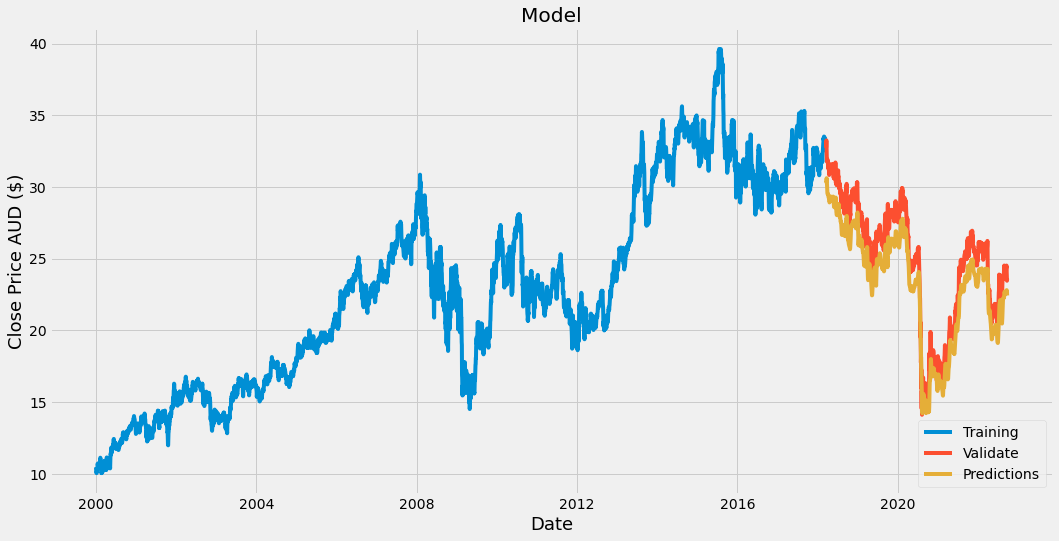

In [64]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.show()


# Test data Predictions on the Model

In [65]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_1000/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Close,Predictions,Difference
4554,32.740002,30.398354,2.341648
4555,33.169998,30.337217,2.832781
4556,33.240002,30.444998,2.795004
4557,32.450001,30.603241,1.846760
4558,32.110001,30.511095,1.598906
...,...,...,...
5679,24.510000,22.718140,1.791860
5680,24.209999,22.794350,1.415649
5681,23.900000,22.782671,1.117329
5682,23.450001,22.664263,0.785738


In [66]:
#Get latest 60 quotes less 1 to predict:

#import pandas_datareader.data as web
#symbol = 'WBC.AX'
#stock_quote = web.DataReader(symbol,data_source='yahoo',start='2022-01-01', end='2022-04-13')
#stock_quotes_sixty = stock_quotes_sixty.filter(['Close'])
#stock_quotes_sixty
#OR use csv data 




In [67]:
# Use last 60 days price on model to predict next days price
stock_quotes_sixty = df_stock_less1.tail(60)
stock_close_sixty = stock_quotes_sixty['Close']
last_60_days = stock_close_sixty[-60:].values
last_60_days = last_60_days.reshape(-1,1)
last_60_days.shape

(60, 1)

In [68]:
last_60_days_scaled = scaler.transform(last_60_days)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [69]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = int(pred_price)
print(f'Predicted next day share price {pred_price}')

Predicted next day share price 22


In [70]:
#stock_quote_acual = web.DataReader('WBC.AX',data_source='yahoo',start='2022-04-14', end='2022-04-14')
#OR get last quote from latest csv
stock_quote_last_one = df_stock1.tail(1)
stock_quote_last_one


,Date,Open,High,Low,Close,Adj Close,Volume,SENTIMENT,RBA,FED
5684,29/04/2022,23.67,23.799999,23.620001,23.790001,23.790001,2016287.0,POSITIVE,0.05,0.08


In [71]:
#save actual to variable
actual_price = stock_quote_last_one.iloc[0,4]
actual_date = stock_quote_last_one.iloc[0,0] 
actual_price = int(actual_price)
actual_price
actual_date


'29/04/2022'

# Save the Model

In [72]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/wbc_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list wbc_sixty and load df

In [73]:
# Read in the CSV file
df_wbc_sixty = pd.read_csv("../static/data/wbc_sixty.csv")
df_wbc_sixty.head()

,20.4
0,20.600000
1,21.070000
2,21.520000
3,21.559999
4,21.850000


In [74]:
close_sixty_val = df_wbc_sixty[-60:].values
last_sixty = close_sixty_val.reshape(-1,1)
last_sixty.shape

(60, 1)

In [75]:
last_sixty_scaled = scaler.transform(last_sixty)
new_X_tell = []
new_X_tell.append(last_sixty_scaled)
new_X_tell =np.array(new_X_tell)
new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
new_X_tell.shape

(1, 60, 1)

#PREDICT USING LOADED MODEL

In [76]:
from keras.models import load_model

In [77]:
model_in = load_model('../static/wbc_model.sav')

In [78]:
model_in_pd_scale = model_in.predict(new_X_tell)
model_in_pd_scale

array([[0.4100938]], dtype=float32)

In [79]:
model_in_price = scaler.inverse_transform(model_in_pd_scale)
#model_in_price_int = int(model_in_price)
print(f'Predicted next day share price {model_in_price}')

Predicted next day share price [[22.16579]]


In [80]:
last_sixty_less_one = np.delete(last_sixty, 0, 0)
last_sixty_less_one.shape

(59, 1)

In [81]:
last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0)
last_sixty.shape

(60, 1)

#Create a function to loop through the days input

In [82]:
from keras.models import load_model
model_in = load_model('../static/wbc_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# Read in the CSV file
df_wbc_sixty = pd.read_csv("../static/data/wbc_sixty.csv")
close_sixty_val = df_wbc_sixty[-60:].values
last_sixty = close_sixty_val.reshape(-1,1)
price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_wbc(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    print(price_list)

In [83]:
predict_wbc(last_sixty,model_in,input)

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

In [84]:
df_len = len(df.index) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,df_len,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

4521 5651 5831


,Close
5820,21.83
5821,21.83
5822,21.83
5823,21.83
5824,21.83
5825,21.83
5826,21.83
5827,21.83
5828,21.83
5829,21.83


C:\Users\antoi\AppData\Local\Temp/ipykernel_1000/3015672197.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


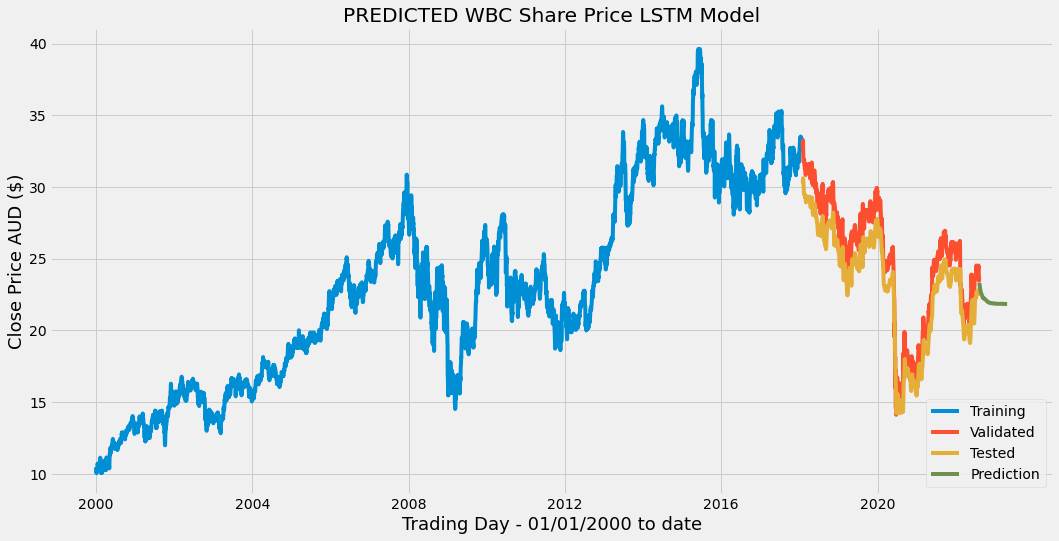

In [85]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:df_len] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[df_len:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTED WBC Share Price LSTM Model')
plt.xlabel('Trading Day - 01/01/2000 to date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training','Validated','Tested','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.show()

#Save predicted price to MongoDB

In [86]:
# # Module used to connect Python with MongoDb
# import pymongo

In [87]:
# # The default port used by MongoDB is 27017
# # https://docs.mongodb.com/manual/reference/default-mongodb-port/
# conn = 'mongodb://localhost:27017'
# client = pymongo.MongoClient(conn)

# # Define the 'sharesDB' database in Mongo
# db = client.sharesDB

In [88]:
# # Query all
# # Here, db.companys refers to the collection 'companys '
# companys = db.companys.find()

# # Iterate through each company in the collection
# for company in companys:
#     print(company)

In [89]:
# # Set keys and values of company
# name = 'WBC'
# predicted = int(pred_price)
# difference = pred_price-actual_price
# print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference}')

In [90]:
# # Insert a document into the 'companys' collection
# db.companys.insert_one(
#     {
#       'model': 'LSTM',
#       'name': name,
#       'date': actual_date,
#       'predicted': predicted,
#       'actual': actual_price,
#       'differece': difference
#     }
# )

# # query the classroom collection
# companys = db.companys.find()

# # see change in collection
# for company in companys:
#     print(company)

In [91]:
# # Delete a document from a collection
# db.companys.delete_one(
#     {'name': 'WBC'}
# )

# # query the companys collection
# companys = db.companys.find()

# # see change in the collection
# for company in companys:
#     print(company)

In [92]:
# from pymongo import MongoClient
# mongoClient = MongoClient()
# db = mongoClient.sharesDB
# db.wbc.drop()

# import csv
# header = ["Date","Open","High","Low","Close","Adj Close","Volume","SENTIMENT","RBA","FED"]
# csvfile = open('../static/data/wbc.csv', 'r')
# reader = csv.DictReader( csvfile )

# for each in reader:
#     row={}
#     for field in header:
#         row[field]=each[field]
        
#     print (row)
#     db.wbc.insert_one(row)				 

In [93]:
# # query the collection
# wbcs = db.wbc.find()

# # see change in collection
# for wbc in wbcs:
#     print(wbc)